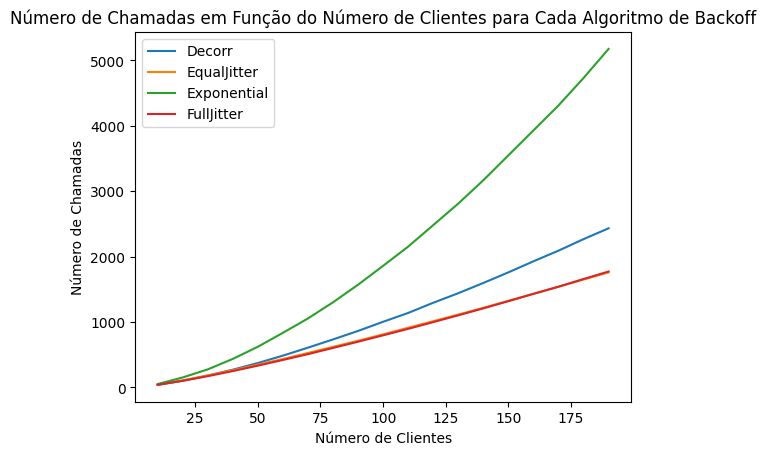

In [1]:
# Simulator for the effects of backoff and jitter on a remote OCC system.
# This code was used for the post on backoff on the AWS architecture blog
# at http://www.awsarchitectureblog.com/
import heapq
import random
import matplotlib.pyplot as plt
import pandas as pd


# Net models the natural delay and variance of the network
class Net:
    def __init__(self, mean, sd):
        self.mean = mean
        self.sd = sd

    def delay(self):
        # We use a normal distribution model. Networks are more likely to be a Weibull model
        # in reality, but this is close enough for the model comparison.
        return abs(random.normalvariate(self.mean, self.sd))


# Base class for all the backoff implementations
class Backoff:
    def __init__(self, base, cap):
        self.base = base
        self.cap = cap

    def expo(self, n):
        return min(self.cap, pow(2, n) * self.base)


class NoBackoff(Backoff):
    def backoff(self, n):
        return 0


class ExpoBackoff(Backoff):
    def backoff(self, n):
        return self.expo(n)


class ExpoBackoffEqualJitter(Backoff):
    def backoff(self, n):
        v = self.expo(n)
        return v / 2 + random.uniform(0, v / 2)


class ExpoBackoffFullJitter(Backoff):
    def backoff(self, n):
        v = self.expo(n)
        return random.uniform(0, v)


class ExpoBackoffDecorr(Backoff):
    def __init__(self, base, cap):
        Backoff.__init__(self, base, cap)
        self.sleep = self.base

    def backoff(self, n):
        self.sleep = min(self.cap, random.uniform(self.base, self.sleep * 3))
        return self.sleep


# Small class to track two counters
class Stats:
    def __init__(self):
        self.failures = 0
        self.calls = 0


# Build a message to be added to the simulated network
def msg(tm, send_to, reply_to, payload):
    assert tm >= 0
    assert send_to is not None
    return (tm, send_to, reply_to, payload)


# The OCC server. It models a single "row" with a single version.
class OccServer:
    def __init__(self, net, stats, ts_f):
        self.version = 0
        self.net = net
        self.stats = stats
        self.ts_f = ts_f

    # Try to write the row. If you provide the right version number (obtained from a read),
    # the write will succeed.
    def write(self, tm, request):
        self.ts_f.write("%d\n" % (tm))
        success = False
        self.stats.calls += 1
        if request[3] == self.version:
            self.version += 1
            success = True
        else:
            self.stats.failures += 1
        return msg(tm + self.net.delay(), request[2], None, success)

    # Read the current version number of the row.
    def read(self, tm, request):
        return msg(tm + self.net.delay(), request[2], None, self.version)


# The OCC client. It models a client that tries to update the row exactly once,
# then stops.
class OccClient:
    def __init__(self, server, net, backoff):
        self.server = server
        self.net = net
        self.attempt = 0
        self.backoff = backoff

    def start(self, tm):
        return msg(tm + self.net.delay(), self.server.read, self.read_rsp, None)

    def read_rsp(self, tm, request):
        return msg(tm + self.net.delay(), self.server.write, self.write_rsp, request[3])

    def write_rsp(self, tm, request):
        if not request[3]:
            self.attempt += 1
            return msg(tm + self.net.delay() + self.backoff.backoff(self.attempt), self.server.read, self.read_rsp,
                       None)
        else:
            return None


# The main loop of the simulation.
def run_sim(queue):
    tm = 0
    while len(queue) > 0:
        # Pull an event off the priority queue
        msg = heapq.heappop(queue)
        assert msg[0] >= tm  # TIme must move forward
        tm = msg[0]
        next_msg = msg[1](tm, msg)
        if next_msg is not None:
            # If it cause another event to be generated, enqueue it
            heapq.heappush(queue, next_msg)
    return tm


# Setup the simulation, creating the clients and server
def setup_sim(clients, backoff_cls, ts_f, stats):
    net = Net(10, 2)
    queue = []
    server = OccServer(net, stats, ts_f)
    for i in range(0, clients):
        client = OccClient(server, net, backoff_cls(5, 2000))
        heapq.heappush(queue, client.start(0))
    return (queue, stats)


# The list of backoff types that we simulate over. The tuples are a class
#  name and a friendly name for the output.
backoff_types = ((ExpoBackoff, "Exponential"),
                 (ExpoBackoffDecorr, "Decorr"),
                 (ExpoBackoffEqualJitter, "EqualJitter"),
                 (ExpoBackoffFullJitter, "FullJitter"),
                 (NoBackoff, "None"))


def run():
    with open("backoff_results.csv", "w") as f:
        f.write("clients,time,calls,Algorithm\n")
        for i in range(1, 20):
            clients = i * 10
            for backoff in backoff_types:
                with open("ts_" + backoff[1], "w") as ts_f:
                    stats = Stats()
                    tm = 0
                    for t in range(0, 100):
                        queue, stats = setup_sim(clients, backoff[0], ts_f, stats)
                        tm += run_sim(queue)
                    f.write("%d,%d,%d,%s\n" % (clients, tm / 100, stats.calls / 100, backoff[1]))


run()

data = pd.read_csv('backoff_results.csv')

grouped_data = data.groupby('Algorithm')

for name, group in grouped_data:
    plt.plot(group['clients'], group['calls'], label=name)

plt.xlabel('Número de Clientes')
plt.ylabel('Número de Chamadas')
plt.title('Número de Chamadas em Função do Número de Clientes para Cada Algoritmo de Backoff')
plt.legend()

plt.show()
